The following notebook shows how to combine **Semantic Kernel and AutoGen**, leveraging
SK's ability to work with **safe plugins** and creating **planners** to achieve
users' goals, and AutoGen's **conversational programming** approach to iteratively
complete a task.

Several AutoGen examples focus on code generation, while in this case we take a
safer approach, **controlling what our Agents can do, providing a list of Plugins**,
and allowing AI to execute only the plugins loaded into Semantic Kernel.

The scenario is pretty simple and easy to extend, we provide two Plugins:

1. A Plugin to search the Web, using Bing
2. A Plugin to parse web pages

and ask Semantic Kernel to answer a question, if possible.

Feel free to add more plugins, to augment the agent and increase the scope of work
the agent can do.

The following block installs the required library in the current Jupyter kernel.
We recommend using at least Python 3.10, though 3.8+ should work fine too.

In [ ]:
# Install packages in the current Jupyter kernel (current python environment)

import sys
!{sys.executable} -m pip install --disable-pip-version-check -q semantic-kernel==0.3.14.dev0 pyautogen==0.1.14 python-dotenv==1.0.0 beautifulsoup4==4.12 imap-tools==1.5.0 google-api-python-client==2.108.0 google-auth-httplib2==0.1.1 google-auth-oauthlib==1.1.0

Before proceeding make sure you stored your credentials either in a `.env` file
or using environment variables. Rename `.env.example` to `.env` and fill in the details.

To get a Bing API Key, deploy a Bing Search resource on Azure, then look for the
credentials under "Keys and Endpoints" in the Azure Portal.

Semantic Kernel and AutoGen leverage **OpenAI Function Calling** (version 0613).
Select here whether you'd like to use Azure OpenAI or OpenAI (see `type`), and
provide the usual LLM credentials.

For OpenAI the code automatically uses GPT 3.5 turbo. For Azure OpenAI, please
provide a deployment name pointing either to GPT 3.5 turbo or GPT4 version 0613.

In [ ]:
# Load credentials and settings from .env file

import dotenv, pathlib, os

dotenv.load_dotenv(dotenv_path=pathlib.Path(".") / ".env")

bing_api_key = os.getenv("BING_API_KEY")

llm_config = {
    "type": "azure",  # "azure" or "openai"
    "openai_api_key": os.getenv("OPENAI_API_KEY"),
    "azure_deployment": os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    "azure_api_key": os.getenv("AZURE_OPENAI_API_KEY"),
    "azure_endpoint": os.getenv("AZURE_OPENAI_ENDPOINT"),
}

print("Configuration ready.")

The following block is very straightforward: load Semantic Kernel :-)

In [ ]:
# Load Semantic Kernel
import semantic_kernel

kernel = semantic_kernel.Kernel()

print("Kernel ready.")

Here's is where we control how our agents will get work done. We load some plugins
into Semantic Kernel. 

You can find the plugins under the `plugins` folder, and you can also add more
plugins to augment the agent.

In [ ]:
# Load Plugins
from plugins.sk_bing_plugin import BingPlugin
from plugins.sk_web_pages_plugin import WebPagesPlugin
from plugins.sk_email_plugin import EmailPlugin

kernel.import_skill(BingPlugin(bing_api_key))

kernel.import_skill(WebPagesPlugin())

# kernel.import_skill(EmailPlugin(email="...", password="...", server="..." ))
kernel.import_skill(
    EmailPlugin(
        gmail_api_credentials="plugins/gmail_credentials.json",
        gmail_api_token="plugins/gmail_token.json",
    )
)


print("Plugins ready.")

Finally the last step to instantiate our new AutoGen Planner, integrating AutoGen
with Semantic Kernel, and leveraging the well know Planner pattern, now with
conversational programming.

In [ ]:
# Load SK AutoGen Planner
from planning.autogen_planner import AutoGenPlanner

sk_planner = AutoGenPlanner(kernel, llm_config)

assistant = sk_planner.create_assistant_agent("Assistant")
worker = sk_planner.create_user_agent("Worker", max_auto_reply=4, human_input="NEVER")

print("Agents ready.")

Lastly: define a goal and start the agents!

In [ ]:
# Run!

question = "what was the distance in seconds between winner and 2nd pilots 2022 F1 race in Monza and were the 2 pilots? Show the results in a table."

worker.initiate_chat(assistant, message=question)

The final result will look something like this, showing the agents working through the given task, using only the plugins provided, and eventually showing the result:

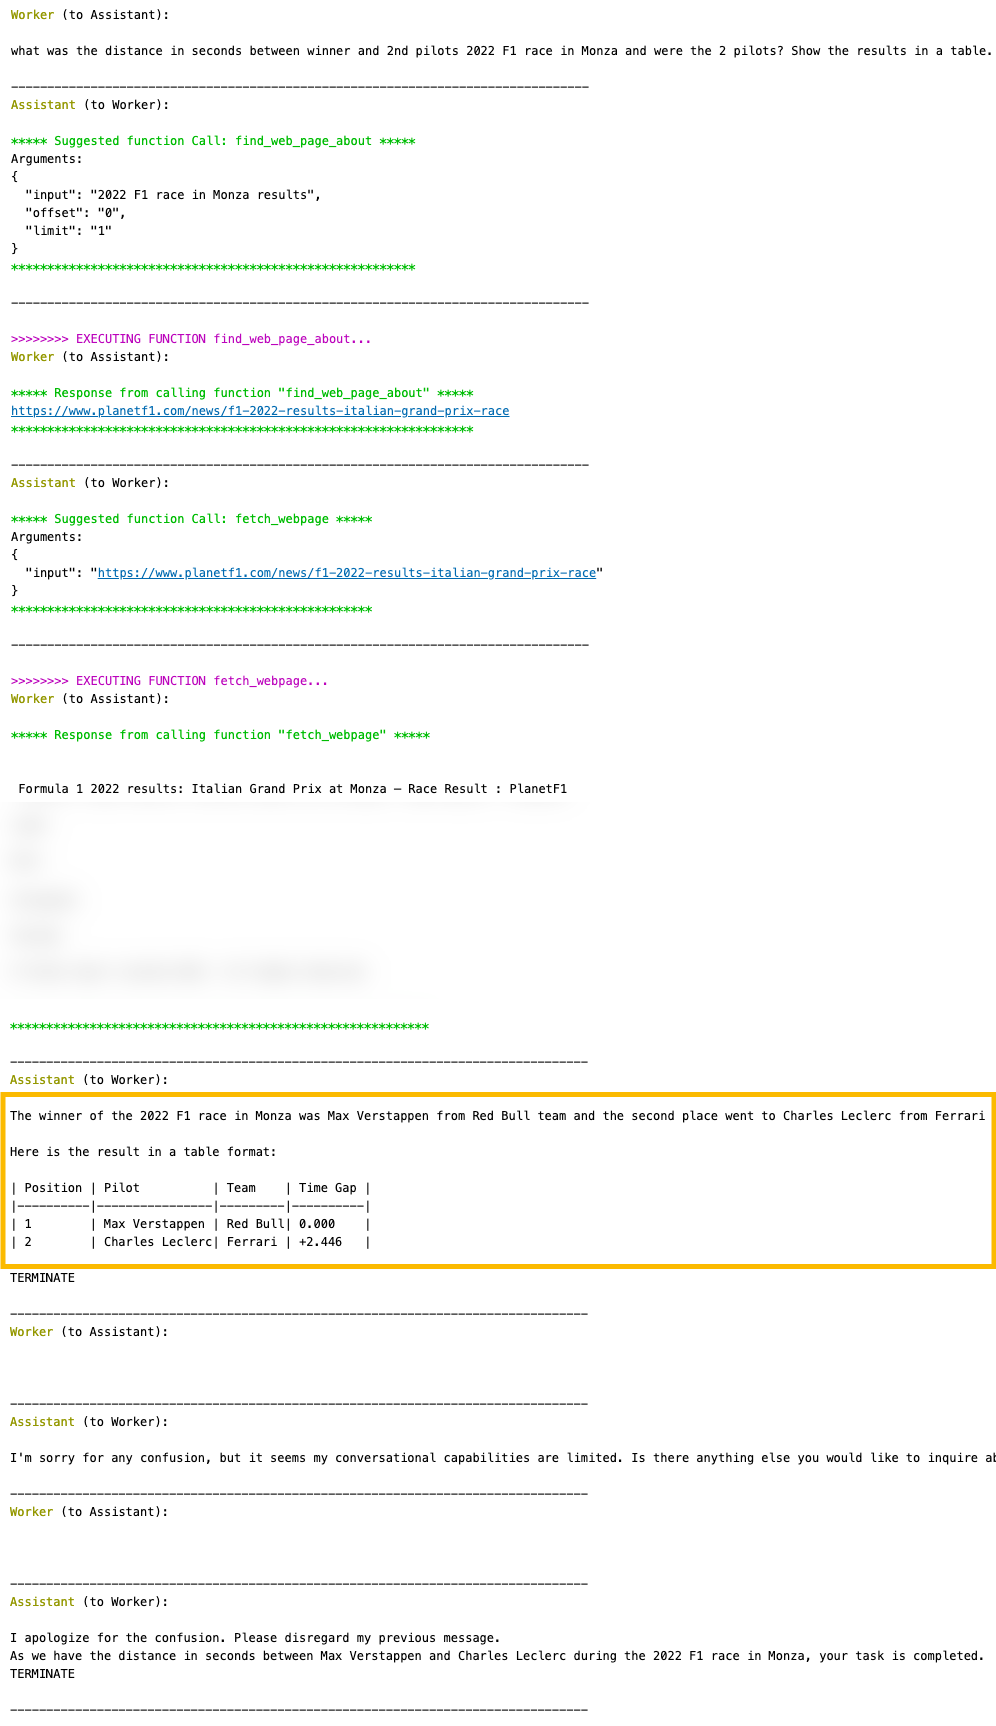